In [5]:
import os

# Example: Set path to your dataset folder
data_dir = r"D:\Brain-Tumor-Detection-main\data"

# List the files to confirm
print("Files in dataset folder:", os.listdir(data_dir))


Files in dataset folder: ['MRI IMAGES']


In [6]:
!pip install tensorflow


In [4]:
pip install tensorflow==2.16.1


^C
Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [ ]:
import sys
print(sys.executable)


d:\anaconda\python.exe


In [ ]:
pip show tensorflow


Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install scikit-learn


In [9]:
!pip install matplotlib


# Imports Libraries and Tools

In [10]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [11]:
# Directories for training and testing data
# Local dataset paths (use raw string r"" for Windows paths)
train_dir = r"D:\Brain-Tumor-Detection-main\data\MRI IMAGES\Training"
test_dir  = r"D:\Brain-Tumor-Detection-main\data\MRI IMAGES\Testing"

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

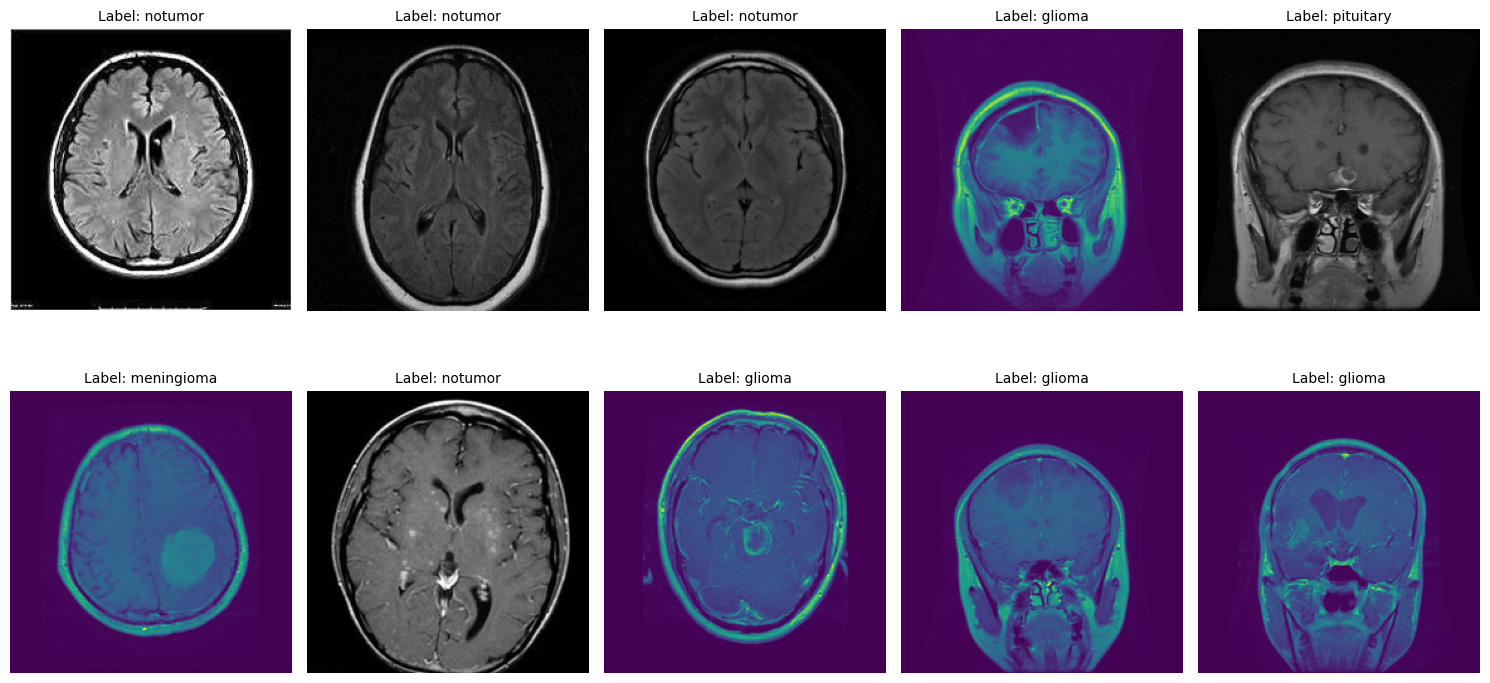

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [22]:

import os
import random
from collections import Counter

import numpy as np
from PIL import Image, ImageEnhance
import cv2

IMAGE_SIZE = 128
DEFAULT_DENOISE_METHOD = 'median' 
SEED=42
random.seed(SEED)
np.random.seed(SEED)


def preprocess_image_path(path,
                          image_size=IMAGE_SIZE,
                          augment=False,
                          denoise=False,
                          denoise_method=DEFAULT_DENOISE_METHOD,
                          keep_uint8=False):
  
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize((image_size, image_size), resample=Image.BILINEAR)
        arr = np.array(img)
    except Exception as e:
        print(f"[WARN] Could not read {path}: {e}")
        arr = np.zeros((image_size, image_size, 3), dtype=np.uint8)

    if denoise and denoise_method:
        try:
            if denoise_method == 'median':
                arr = cv2.medianBlur(arr, 5)
            elif denoise_method == 'gaussian':
                arr = cv2.GaussianBlur(arr, (5, 5), 0)
            elif denoise_method == 'bilateral':
                arr = cv2.bilateralFilter(arr, d=9, sigmaColor=75, sigmaSpace=75)
        except Exception:
            pass

    if augment:
        pil = Image.fromarray(arr)
        pil = ImageEnhance.Brightness(pil).enhance(random.uniform(0.85, 1.15))
        pil = ImageEnhance.Contrast(pil).enhance(random.uniform(0.85, 1.15))
        angle = random.uniform(-12, 12)
        pil = pil.rotate(angle, resample=Image.BILINEAR, fillcolor=(0, 0, 0))
        if random.random() < 0.5:
            pil = pil.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.3:
            w, h = pil.size
            zx = random.uniform(0.92, 1.0)
            new_w, new_h = int(w * zx), int(h * zx)
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            pil = pil.crop((left, top, left + new_w, top + new_h)).resize((w, h), Image.BILINEAR)
        arr = np.array(pil)

    if keep_uint8:
        return arr

    return arr.astype('float32') / 255.0


def open_images(paths, augment=False, denoise=False, denoise_method=DEFAULT_DENOISE_METHOD, verbose=False):
   
    images = []
    for p in paths:
        try:
            im = preprocess_image_path(p, IMAGE_SIZE, augment=augment, denoise=denoise, denoise_method=denoise_method)
            images.append(im)
        except Exception as e:
            if verbose:
                print(f"[WARN] failed to process {p}: {e}")
    if len(images) == 0:
        return np.zeros((0, IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
    return np.stack(images, axis=0)


def encode_labels(labels, class_names=None):
    
    if class_names is None:
        class_names = sorted(list(set(labels)))
    mapping = {c: i for i, c in enumerate(class_names)}
    return np.array([mapping[l] for l in labels])


def datagen(paths, labels, batch_size=32, denoise=False, denoise_method=DEFAULT_DENOISE_METHOD,epochs=1):
   
    n = len(paths)
    idxs = np.arange(n)
    while True:
        np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idx = idxs[i:i + batch_size]
            batch_paths = [paths[j] for j in batch_idx]
            batch_labels = [labels[j] for j in batch_idx]
            batch_x = open_images(batch_paths, augment=True, denoise=denoise, denoise_method=denoise_method)
            batch_y = encode_labels(batch_labels, class_names=sorted(list(set(labels))))
            yield batch_x, batch_y



def show_before_after(path, denoise=False, denoise_method=DEFAULT_DENOISE_METHOD):
    import matplotlib.pyplot as plt
    raw = Image.open(path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    proc = preprocess_image_path(path, IMAGE_SIZE, augment=False, denoise=denoise, denoise_method=denoise_method)
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1); plt.imshow(raw); plt.title('Raw'); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(proc); plt.title('Preprocessed'); plt.axis('off')
    plt.show()


def dataset_summary(train_paths, train_labels, test_paths=None, test_labels=None):
    """Prints quick counts and distributions for train/test sets."""
    print("Train count:", len(train_paths))
    print(Counter(train_labels))
    if test_paths is not None and test_labels is not None:
        print("Test count:", len(test_paths))
        print(Counter(test_labels))


if __name__ == '__main__':
    print('preprocess.py loaded.')



preprocess.py loaded.


# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [23]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - loss: 0.4744 - sparse_categorical_accuracy: 0.8142
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - loss: 0.2601 - sparse_categorical_accuracy: 0.9055
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 273s 959ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9280
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 283s 993ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.9392
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 0.1283 - sparse_categorical_accuracy: 0.9531


In [15]:
!pip install seaborn

# Train and Val Plots

# Model Classification Report

<>:15: SyntaxWarning: invalid escape sequence '\M'
<>:15: SyntaxWarning: invalid escape sequence '\M'
C:\Users\DELL\AppData\Local\Temp\ipykernel_23828\1050639515.py:15: SyntaxWarning: invalid escape sequence '\M'
  TEST_DIR = "D:\ML-PROJECT\data\MRI IMAGES\Testing"                # put test images in ./test/<class>/*.jpg


Found 1311 test images across 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Loading model...


Model loaded. Input shape: (None, 128, 128, 3)
Loading test images...
Class mapping: {0: np.str_('glioma'), 1: np.str_('meningioma'), 2: np.str_('notumor'), 3: np.str_('pituitary')}
Running prediction...
41/41 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      glioma       0.98      0.80      0.88       300
  meningioma       0.83      0.92      0.87       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311



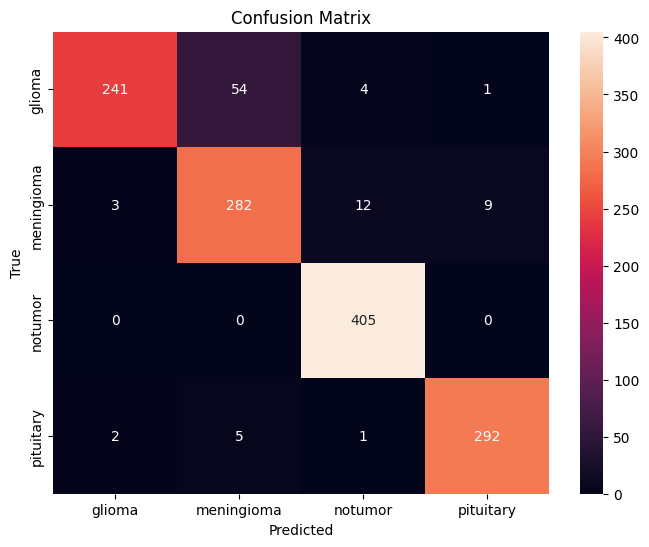

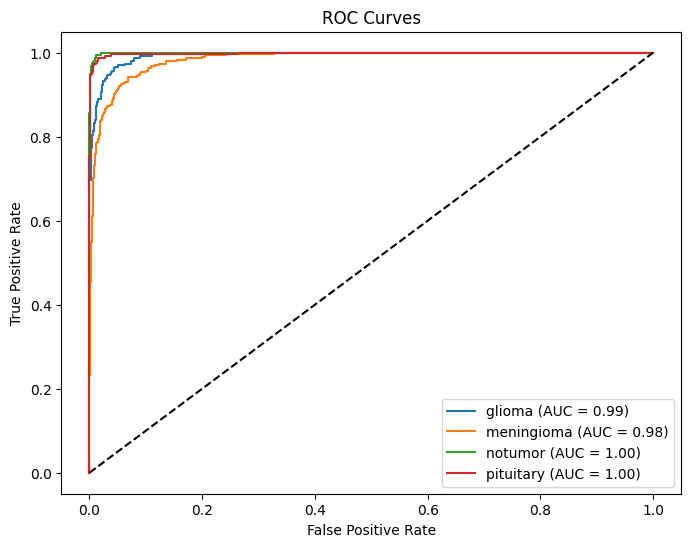

In [50]:
# === Standalone evaluation cell: classification report, confusion matrix, ROC ===
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# --------- CONFIGURE PATHS ----------
MODEL_PATH = "model.h5"   # put your model here
TEST_DIR = "D:\ML-PROJECT\data\MRI IMAGES\Testing"                # put test images in ./test/<class>/*.jpg
TARGET_SIZE = (128, 128)         # model expects 128x128 in your code

# --------- sanity checks ----------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}. Place your .h5 file there or change MODEL_PATH.")

if not os.path.isdir(TEST_DIR):
    raise FileNotFoundError(f"Test folder not found: {TEST_DIR}. Create folder structure {TEST_DIR}/<class>/*.jpg")

# --------- gather test image paths and labels ----------
classes = sorted([d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))])
if len(classes) == 0:
    raise FileNotFoundError(f"No class subfolders found inside {TEST_DIR}. Expected structure {TEST_DIR}/<class>/*.jpg")

test_paths, test_labels = [], []
for cls in classes:
    cls_folder = os.path.join(TEST_DIR, cls)
    for fname in sorted(os.listdir(cls_folder)):
        if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
            test_paths.append(os.path.join(cls_folder, fname))
            test_labels.append(cls)

print(f"Found {len(test_paths)} test images across {len(classes)} classes: {classes}")

# --------- helper to load images simply (no augmentation) ----------
def load_images_simple(paths, target_size=TARGET_SIZE):
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        img = img.resize(target_size)
        arr = np.array(img, dtype=np.float32) / 255.0
        imgs.append(arr)
    return np.array(imgs, dtype=np.float32)

# --------- load model & images ----------
print("Loading model...")
model = load_model(MODEL_PATH)
print("Model loaded. Input shape:", model.input_shape)

print("Loading test images...")
X_test = load_images_simple(test_paths, target_size=TARGET_SIZE)
y_labels = np.array(test_labels)

# --------- encode labels and predict ----------
le = LabelEncoder()
y_true = le.fit_transform(y_labels)
class_names = le.classes_
print("Class mapping:", dict(zip(range(len(class_names)), class_names)))

print("Running prediction...")
y_prob = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_prob, axis=1)

# --------- classification report ----------
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# --------- confusion matrix ----------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --------- multiclass ROC / AUC (one-vs-rest) ----------
n_classes = y_prob.shape[1]
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError:
        fpr[i], tpr[i], roc_auc[i] = np.array([0,1]), np.array([0,1]), np.nan

plt.figure(figsize=(8,6))
for i in range(n_classes):
    if not np.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


# Save & Load Model

In [37]:
# Save the entire model
model.save('model.h5')

In [38]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# MRI Tumor Detection System

In [39]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


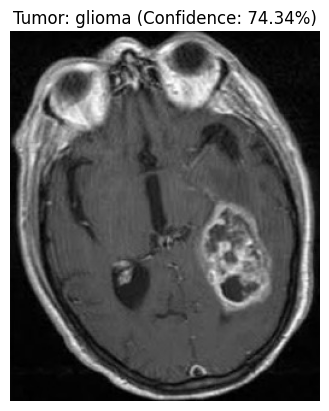

In [40]:
# Example usage
image_path = 'Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


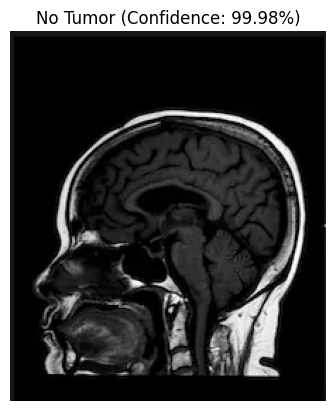

In [42]:

# Example usage
image_path = r"D:\ML-PROJECT\Te-noTr_0004.jpg"  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


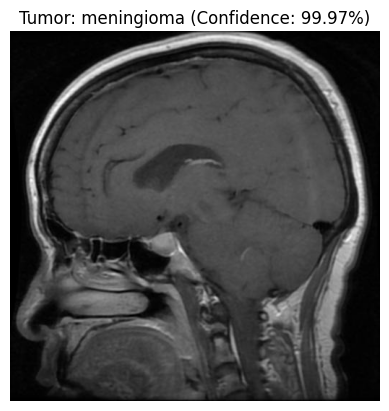

In [44]:
# Example usage
image_path = "D:/ML-PROJECT/Te-piTr_0003.jpg"
 # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


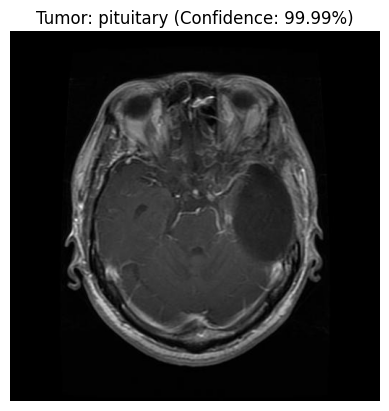

In [45]:
# Example usage
image_path = r"D:\ML-PROJECT\Te-gl_0015.jpg" # Provide the path to your new image
detect_and_display(image_path, model)